## Regression with BIWI head pose dataset

20190108

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from fastai import *
from fastai.vision import *

## Getting and converting the data

In [10]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [11]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [12]:
fname = '09/frame_00667_rgb.jpg'

In [13]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

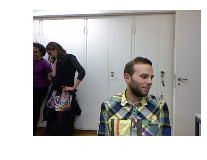

In [14]:
img = open_image(path/fname)
img.show()

In [15]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

looking at `convert_biwi` and later the result of `get_ctr(.)`, looks like the XBOX Kinnect they used measures in x,y,z coordinates (only the 1st 2 dims are used to calculate center, and they're switched x,y -> r,c)

In [35]:
# (path/'13').ls()

In [16]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [17]:
get_ctr(fname)

tensor([263.9104, 428.5814])

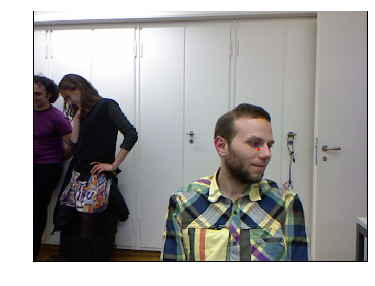

In [18]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

---
#### Debugging Data Block Error

In [45]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
#         .split_by_valid_func(get_ctr)
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

OSError: /home/jupyter/.fastai/data/biwi_head_posepose.txt not found.

Debugging to find the issue:

In [46]:
%debug

> /opt/anaconda3/lib/python3.6/site-packages/numpy/lib/_datasource.py(618)open()
    616                                       encoding=encoding, newline=newline)
    617         else:
--> 618             raise IOError("%s not found." % path)
    619 
    620 



ipdb>  path


'/home/jupyter/.fastai/data/biwi_head_posepose.txt'


ipdb>  l


    613             if ext == 'bz2':
    614                 mode.replace("+", "")
    615             return _file_openers[ext](found, mode=mode,
    616                                       encoding=encoding, newline=newline)
    617         else:
--> 618             raise IOError("%s not found." % path)
    619 
    620 
    621 class Repository (DataSource):
    622     """
    623     Repository(baseurl, destpath='.')



ipdb>  h



Documented commands (type help <topic>):
EOF    cl         disable  interact  next    psource  rv         unt   
a      clear      display  j         p       q        s          until 
alias  commands   down     jump      pdef    quit     source     up    
args   condition  enable   l         pdoc    r        step       w     
b      cont       exit     list      pfile   restart  tbreak     whatis
break  continue   h        ll        pinfo   return   u          where 
bt     d          help     longlist  pinfo2  retval   unalias  
c      debug      ignore   n         pp      run      undisplay

Miscellaneous help topics:
exec  pdb



ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/numpy/lib/_datasource.py(262)open()
    260 
    261     ds = DataSource(destpath)
--> 262     return ds.open(path, mode, encoding=encoding, newline=newline)
    263 
    264 



ipdb>  path


'/home/jupyter/.fastai/data/biwi_head_posepose.txt'


ipdb>  l


    257     returns the file object from ``DataSource.open(path)``.
    258 
    259     """
    260 
    261     ds = DataSource(destpath)
--> 262     return ds.open(path, mode, encoding=encoding, newline=newline)
    263 
    264 
    265 class DataSource (object):
    266     """
    267     DataSource(destpath='.')



ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py(1707)genfromtxt()
   1705         raise TypeError(
   1706             "fname must be a string, filehandle, list of strings, "
-> 1707             "or generator. Got %s instead." % type(fname))
   1708 
   1709     split_line = LineSplitter(delimiter=delimiter, comments=comments,



ipdb>  l


   1702         else:
   1703             fhd = iter(fname)
   1704     except TypeError:
   1705         raise TypeError(
   1706             "fname must be a string, filehandle, list of strings, "
-> 1707             "or generator. Got %s instead." % type(fname))
   1708 
   1709     split_line = LineSplitter(delimiter=delimiter, comments=comments,
   1710                               autostrip=autostrip, encoding=encoding)
   1711     validate_names = NameValidator(excludelist=excludelist,
   1712                                    deletechars=deletechars,



ipdb>  fname


'/home/jupyter/.fastai/data/biwi_head_posepose.txt'


ipdb>  u


> <ipython-input-42-95ece560ca93>(2)get_ctr()
      1 def get_ctr(f):
----> 2     ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
      3     return
      4 #     if ctr=='biwi_head_posepose.txt':
      5 #         print(ctr)



ipdb>  !f


PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/07.obj')


ipdb>  ctr


tensor([263.9104, 428.5814])


ipdb>  img2txt_name(f)


PosixPath('/home/jupyter/.fastai/data/biwi_head_posepose.txt')


ipdb>  d


> /opt/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py(1707)genfromtxt()
   1705         raise TypeError(
   1706             "fname must be a string, filehandle, list of strings, "
-> 1707             "or generator. Got %s instead." % type(fname))
   1708 
   1709     split_line = LineSplitter(delimiter=delimiter, comments=comments,



ipdb>  d


> /opt/anaconda3/lib/python3.6/site-packages/numpy/lib/_datasource.py(262)open()
    260 
    261     ds = DataSource(destpath)
--> 262     return ds.open(path, mode, encoding=encoding, newline=newline)
    263 
    264 



ipdb>  d


> /opt/anaconda3/lib/python3.6/site-packages/numpy/lib/_datasource.py(618)open()
    616                                       encoding=encoding, newline=newline)
    617         else:
--> 618             raise IOError("%s not found." % path)
    619 
    620 



ipdb>  d


*** Newest frame


ipdb>  d


*** Newest frame


ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/numpy/lib/_datasource.py(262)open()
    260 
    261     ds = DataSource(destpath)
--> 262     return ds.open(path, mode, encoding=encoding, newline=newline)
    263 
    264 



ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py(1707)genfromtxt()
   1705         raise TypeError(
   1706             "fname must be a string, filehandle, list of strings, "
-> 1707             "or generator. Got %s instead." % type(fname))
   1708 
   1709     split_line = LineSplitter(delimiter=delimiter, comments=comments,



ipdb>  u


> <ipython-input-42-95ece560ca93>(2)get_ctr()
      1 def get_ctr(f):
----> 2     ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
      3     return
      4 #     if ctr=='biwi_head_posepose.txt':
      5 #         print(ctr)



ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(179)<listcomp>()
    177     def split_by_valid_func(self, func:Callable)->'ItemLists':
    178         "Split the data by result of `func` (which returns `True` for validation set)."
--> 179         valid_idx = [i for i,o in enumerate(self.items) if func(o)]
    180         return self.split_by_idx(valid_idx)
    181 



ipdb>  !o


PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/07.obj')


ipdb>  !i


0


ipdb>  func


<function get_ctr at 0x7f9b46e7eb70>


ipdb>  func(o)


*** OSError: /home/jupyter/.fastai/data/biwi_head_posepose.txt not found.


ipdb>  !o


PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/07.obj')


ipdb>  q


Modifying `get_ctr` to see if I could control the error: (didn't work)

In [51]:
path.suffix

''

In [52]:
def get_ctr(f):
    if f.suffix == '':
        ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
        return convert_biwi(ctr)
    else:
        return

The filename `PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/07.obj')` is fed into `get_ctr` within the call to `.split_by_valid_func(get_ctr)`, and this is causing the error.

Testing on the `'07'` directory:

In [53]:
get_ctr(Path('/home/jupyter/.fastai/data/biwi_head_pose/07'))

OSError: /home/jupyter/.fastai/data/biwi_head_pose.txt not found.

Not the case (doesn't reproduce the error's output. Testing on the `'07.obj'` file:

Checking the output of `img2txt_name` on that filepath:

In [54]:
img2txt_name(Path('/home/jupyter/.fastai/data/biwi_head_pose/07.obj'))

PosixPath('/home/jupyter/.fastai/data/biwi_head_posepose.txt')

In [48]:
get_ctr(Path('/home/jupyter/.fastai/data/biwi_head_pose/07.obj'))

OSError: /home/jupyter/.fastai/data/biwi_head_posepose.txt not found.

Checking if this can be solved by removing all object files in the `path`:

In [56]:
!rm -rf {path}/*.obj

Removal successful, constructing data block:

In [81]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

AttributeError: 'PosixPath' object has no attribute 'reshape'

Looking for what's going on now..

In [82]:
%debug

> /opt/anaconda3/lib/python3.6/site-packages/fastai/vision/data.py(379)__init__()
    377 class PointsProcessor(PreProcessor):
    378     "`PreProcessor` that stores the number of targets for point regression."
--> 379     def __init__(self, ds:ItemList): self.c = len(ds.items[0].reshape(-1))
    380     def process(self, ds:ItemList):  ds.c = self.c
    381 



ipdb>  ds.items[0]


PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/readme.txt')


ipdb>  ds.items


array([PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/readme.txt'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/io_sample.cpp'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04/frame_00335_pose.txt'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04/frame_00255_rgb.jpg'), ...,
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/19/frame_00487_pose.txt'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/19/frame_00484_pose.txt'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/19/frame_00033_pose.txt'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/19/frame_00359_rgb.jpg')], dtype=object)


ipdb>  q


My guess now is that the `readme.txt` (and later `io_sample.cpp`) files are screwing up the data block constructor. Let's see about removing those.

In [84]:
!rm {path}/readme.txt
!rm {path}/io_sample.cpp

In [85]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

AttributeError: 'PosixPath' object has no attribute 'reshape'

In [87]:
%debug

> /opt/anaconda3/lib/python3.6/site-packages/fastai/vision/data.py(379)__init__()
    377 class PointsProcessor(PreProcessor):
    378     "`PreProcessor` that stores the number of targets for point regression."
--> 379     def __init__(self, ds:ItemList): self.c = len(ds.items[0].reshape(-1))
    380     def process(self, ds:ItemList):  ds.c = self.c
    381 



ipdb>  ds.items


array([PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04/frame_00335_pose.txt'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04/frame_00255_rgb.jpg'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04/frame_00320_pose.txt'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04/frame_00586_pose.txt'), ...,
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/19/frame_00487_pose.txt'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/19/frame_00484_pose.txt'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/19/frame_00033_pose.txt'),
       PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/19/frame_00359_rgb.jpg')], dtype=object)


ipdb>  ds.items[0]


PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04/frame_00335_pose.txt')


ipdb>  q


So now... somehow I have to open the file for reshaping, and as things stand that's not happening. Just the filepath is being passed through...

Wait no.. `get_ctr` should return a tensor of the label. Why isn't it doing that?

In [89]:
get_ctr(Path('/home/jupyter/.fastai/data/biwi_head_pose/04/frame_00335_pose.txt')
)

*Oh*, becuase I editted `get_ctr` when I was debugging the previous error.

In [90]:
def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

In [94]:
get_ctr(Path('/home/jupyter/.fastai/data/biwi_head_pose/04/frame_00335_pose.txt')
)

OSError: /home/jupyter/.fastai/data/biwi_head_pose/04/frame_00335_ppose.txt not found.

Oh, and `get_ctr` is supposed to take a filename *only*, I was mistakenly giving it an entire Path.

In [92]:
get_ctr('09/frame_00667_rgb.jpg')

tensor([263.9104, 428.5814])

In [93]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

OSError: /home/jupyter/.fastai/data/biwi_head_pose/04/frame_00335_ppose.txt not found.

This looks just like an error I just got, by passing in a filepath instead of a filename. So how to correct that (and why is the lesson notebook causing these problems anyway?)?

Okay, this problem is happening because `img2txt_name` is being given a `pose.txt` file instead of a `_rgb.jpg` file. This function *creates*.... ***oh***.

Something about this dataset.. it's as if it contains both parts that don't belong for deep learning (the object files), and parts that are generated by -- no.. The .txt files aren't generated by the datablock constructor, they're found by referencing the filenames of the jpg files.

But if the constructor blindly reads all files, this is never going to work, unless I:

1. move all .txt files to another folder and modify `img2txt_name` to output the correct filepath.

2. find a way to get the constructor to only look at .jpg files.

I know how to do 1., but I feel like 2. is the less messy solution, although I have no idea how to do it yet.

In [96]:
??PointsItemList.from_folder

Signature: PointsItemList.from_folder(path:Union[pathlib.Path, str], extensions:Collection[str]=None, recurse=True, include:Union[Collection[str], NoneType]=None, **kwargs) -> 'ItemList'
Source:   
    @classmethod
    def from_folder(cls, path:PathOrStr, extensions:Collection[str]=None, recurse=True,
                    include:Optional[Collection[str]]=None, **kwargs)->'ItemList':
        "Create an `ItemList` in `path` from the filenames that have a suffix in `extensions`. `recurse` determines if we search subfolders."
        path = Path(path)
        return cls(get_files(path, extensions, recurse=recurse, include=include), path=path, **kwargs)
File:      /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py
Type:      method


if I can specify `extensions` this issue *should* be resolved.

In [97]:
data = (PointsItemList.from_folder(path, extensions='.jpg')
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

AttributeError: 'PosixPath' object has no attribute 'reshape'

In [98]:
%debug

> /opt/anaconda3/lib/python3.6/site-packages/fastai/vision/data.py(379)__init__()
    377 class PointsProcessor(PreProcessor):
    378     "`PreProcessor` that stores the number of targets for point regression."
--> 379     def __init__(self, ds:ItemList): self.c = len(ds.items[0].reshape(-1))
    380     def process(self, ds:ItemList):  ds.c = self.c
    381 



ipdb>  d


*** Newest frame


ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(415)<listcomp>()
    413         "Read the default class processors if none have been set."
    414         procs_x,procs_y = listify(self.train.x._processor),listify(self.train.y._processor)
--> 415         xp = ifnone(self.train.x.processor, [p(ds=self.train.x) for p in procs_x])
    416         yp = ifnone(self.train.y.processor, [p(ds=self.train.y) for p in procs_y])
    417         return xp,yp



ipdb>  procs_x


*** NameError: name 'procs_x' is not defined


ipdb>  self.train.x


*** AttributeError: 'NoneType' object has no attribute 'sizes'


ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(415)get_processors()
    413         "Read the default class processors if none have been set."
    414         procs_x,procs_y = listify(self.train.x._processor),listify(self.train.y._processor)
--> 415         xp = ifnone(self.train.x.processor, [p(ds=self.train.x) for p in procs_x])
    416         yp = ifnone(self.train.y.processor, [p(ds=self.train.y) for p in procs_y])
    417         return xp,yp



ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(421)process()
    419     def process(self):
    420         "Process the inner datasets."
--> 421         xp,yp = self.get_processors()
    422         for i,ds in enumerate(self.lists): ds.process(xp, yp, filter_missing_y=i==0)
    423         return self



ipdb>  xp


*** NameError: name 'xp' is not defined


ipdb>  self.get_processors()


*** AttributeError: 'PosixPath' object has no attribute 'reshape'


ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(375)_inner()
    373             self.valid = fv(*args, **kwargs)
    374             self.__class__ = LabelLists
--> 375             self.process()
    376             return self
    377         return _inner



ipdb>  u


> <ipython-input-97-3468e8ece8dc>(3)<module>()
      1 data = (PointsItemList.from_folder(path, extensions='.jpg')
      2         .split_by_valid_func(lambda o: o.parent.name=='13')
----> 3         .label_from_func(get_ctr)
      4         .transform(get_transforms(), tfm_y=True, size=(120,160))
      5         .databunch().normalize(imagenet_stats)



ipdb>  q


In [99]:
data = (PointsItemList.from_folder(path, extensions='jpg')
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

IndexError: index 0 is out of bounds for axis 0 with size 0

In [100]:
%debug

> /opt/anaconda3/lib/python3.6/site-packages/fastai/core.py(220)index_row()
    218         if isinstance(res,(pd.DataFrame,pd.Series)): return res.copy()
    219         return res
--> 220     return a[idxs]
    221 
    222 def func_args(func)->bool:



ipdb>  !a


array([], dtype=object)


ipdb>  l


    215     if a is None: return a
    216     if isinstance(a,(pd.DataFrame,pd.Series)):
    217         res = a.iloc[idxs]
    218         if isinstance(res,(pd.DataFrame,pd.Series)): return res.copy()
    219         return res
--> 220     return a[idxs]
    221 
    222 def func_args(func)->bool:
    223     "Return the arguments of `func`."
    224     code = func.__code__
    225     return code.co_varnames[:code.co_argcount]



ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(201)get_label_cls()
    199         if label_cls is not None:               return label_cls
    200         if self.label_cls is not None:          return self.label_cls
--> 201         it = index_row(labels,0)
    202         if sep is not None:                     return MultiCategoryList
    203         if isinstance(it, (float, np.float32)): return FloatList



ipdb>  labels


array([], dtype=object)


ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(211)label_from_list()
    209         "Label `self.items` with `labels`."
    210         labels = array(labels, dtype=object)
--> 211         label_cls = self.get_label_cls(labels, **kwargs)
    212         y = label_cls(labels, path=self.path, **kwargs)
    213         res = self._label_list(x=self, y=y)



ipdb>  labels


array([], dtype=object)


ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(231)label_from_func()
    229     def label_from_func(self, func:Callable, **kwargs)->'LabelList':
    230         "Apply `func` to every input to get its label."
--> 231         return self.label_from_list([func(o) for o in self.items], **kwargs)
    232 
    233     def label_from_folder(self, **kwargs)->'LabelList':



ipdb>  self.items


array([], dtype=object)


ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(371)_inner()
    369         assert isinstance(fv, Callable)
    370         def _inner(*args, **kwargs):
--> 371             self.train = ft(*args, **kwargs)
    372             assert isinstance(self.train, LabelList)
    373             self.valid = fv(*args, **kwargs)



ipdb>  q


I don't know what's going on. The function `ft` within the method `_inner` of the data_block class `ItemList` corresponds to the data_block function `label_from_func`. Unfortunately, `self.items` yields an empty list, and that empty list gets passed all the way through until another function tries to index into it causing an IndexError.

So the question is why is `self.items`, which is `ItemList.items` which is `PointsItemList.items`, returning an empty list?

Aha, I got a different error before didn't I? So that may answer my previous question: do I give `extensions` 'jpg' or '.jpg'. If giving it 'jpg' leads to this error, then perhaps the constructor didn't find any matches, thus giving me an empty list.

So then what's up with the error when the constructor is presumably able to find the jpg files with the '.jpg' extension argument?

In [101]:
data = (PointsItemList.from_folder(path, extensions='.jpg')
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

AttributeError: 'PosixPath' object has no attribute 'reshape'

In [102]:
%debug

> /opt/anaconda3/lib/python3.6/site-packages/fastai/vision/data.py(379)__init__()
    377 class PointsProcessor(PreProcessor):
    378     "`PreProcessor` that stores the number of targets for point regression."
--> 379     def __init__(self, ds:ItemList): self.c = len(ds.items[0].reshape(-1))
    380     def process(self, ds:ItemList):  ds.c = self.c
    381 



ipdb>  !ds


*** AttributeError: 'NoneType' object has no attribute 'sizes'


ipdb>  len(ds.items[0].reshape(-1))


*** AttributeError: 'PosixPath' object has no attribute 'reshape'


ipdb>  ds.items[0]


PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04/frame_00255_rgb.jpg')


ipdb>  !ds


*** AttributeError: 'NoneType' object has no attribute 'sizes'


ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(415)<listcomp>()
    413         "Read the default class processors if none have been set."
    414         procs_x,procs_y = listify(self.train.x._processor),listify(self.train.y._processor)
--> 415         xp = ifnone(self.train.x.processor, [p(ds=self.train.x) for p in procs_x])
    416         yp = ifnone(self.train.y.processor, [p(ds=self.train.y) for p in procs_y])
    417         return xp,yp



ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(415)get_processors()
    413         "Read the default class processors if none have been set."
    414         procs_x,procs_y = listify(self.train.x._processor),listify(self.train.y._processor)
--> 415         xp = ifnone(self.train.x.processor, [p(ds=self.train.x) for p in procs_x])
    416         yp = ifnone(self.train.y.processor, [p(ds=self.train.y) for p in procs_y])
    417         return xp,yp



ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(421)process()
    419     def process(self):
    420         "Process the inner datasets."
--> 421         xp,yp = self.get_processors()
    422         for i,ds in enumerate(self.lists): ds.process(xp, yp, filter_missing_y=i==0)
    423         return self



ipdb>  u


> /opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py(375)_inner()
    373             self.valid = fv(*args, **kwargs)
    374             self.__class__ = LabelLists
--> 375             self.process()
    376             return self
    377         return _inner



ipdb>  u


> <ipython-input-101-3468e8ece8dc>(3)<module>()
      1 data = (PointsItemList.from_folder(path, extensions='.jpg')
      2         .split_by_valid_func(lambda o: o.parent.name=='13')
----> 3         .label_from_func(get_ctr)
      4         .transform(get_transforms(), tfm_y=True, size=(120,160))
      5         .databunch().normalize(imagenet_stats)



ipdb>  q


In [107]:
get_ctr(Path('04/frame_00255_rgb.jpg'))

tensor([236.8683, 411.7458])

Could it be that the full path somehow is being returned? Because `get_ctr` does its job. I don't think so, because the error happens in a reshaping operation.. so it's a dataset issue? But that shouldn't happen -- it should return tensors, not filepaths.. what's going on? I'll check anyway:

In [108]:
def boom(x):
    return get_ctr(x.parent/x.name)

In [109]:
data = (PointsItemList.from_folder(path, extensions='.jpg')
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(boom)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

AttributeError: 'PosixPath' object has no attribute 'reshape'

Alright, I'ts 4:36 AM, I started around midnight, I'm packing this in for the night. I may leave this where it is as a notebook, just because of all the debugging. I'll get back on this tomorrow and figure out how to get it working then.

-- WNixalo

-----

In [72]:
data.show_batch(3, figsize=(9,6))

AttributeError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2613, in open
    fp.seek(0)
AttributeError: 'NoneType' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py", line 483, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/data_block.py", line 92, in __getitem__
    if isinstance(try_int(idxs), int): return self.get(idxs)
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/vision/data.py", line 266, in get
    res = self.open(fn)
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/vision/data.py", line 262, in open
    return open_image(fn, convert_mode=self.convert_mode)
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/vision/image.py", line 376, in open_image
    x = PIL.Image.open(fn).convert(convert_mode)
  File "/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2615, in open
    fp = io.BytesIO(fp.read())
AttributeError: 'NoneType' object has no attribute 'read'


In [65]:
data = (PointsItemList.from_folder(path)
        .label_from_func(get_ctr)
        .split_by_valid_func(lambda o: o.parent.name=='13')
#         .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

AttributeError: 'PointsItemList' object has no attribute 'databunch'

In [ ]:
data.show_batch(3, figsize=(9,6))

## Train model

In [ ]:
learn = create_cnn(data, models.resnet34)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 2e-2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results()

## Data augmentation

In [ ]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (ImageItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr, label_cls=PointsItemList)
        .transform(tfms, tfm_y=True, size=(120,160), padding_mode='zeros')
        .databunch().normalize(imagenet_stats)
       )

In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))